# Daily Retreat: Using Sentiment Analysis to<br>Find, Personalize, and Share Positive News from Popular Online Sources
__Aaron Carr, Azucena Faus, and Dave Friesen - ADS-599-01-SU23__

## Setup

In [1]:
#! pip install pyLDavis

import numpy as np
import pandas as pd

# Text preprocessing libraries
import requests
import os
import shutil
import re
import logging
import time
import zipfile
import requests
from bs4 import BeautifulSoup
import datetime
import re
import regex as rex
from bs4 import BeautifulSoup
import datetime
import json
from string import punctuation
from nltk.corpus import stopwords
import re
import emoji
import itertools
import pickle

# EDA for text libraries
import nltk
import collections
import textstat
from collections import defaultdict, Counter
from gensim.corpora import Dictionary
import random
#import textacy.preprocessing as tprep
#from textacy.extract import keyword_in_context
import pyLDAvis
pyLDAvis.enable_notebook()
from tqdm.auto import tqdm
#import spacy
import pyLDAvis.lda_model
import pyLDAvis.gensim_models
from wordcloud import WordCloud 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation
from gensim import models, interfaces, utils
from gensim.models import Nmf
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import TfidfModel
from gensim.models import LdaModel
from gensim.models.ldamulticore import LdaMulticore


# visuals
import matplotlib.pyplot as plt
import seaborn as sns
import calendar 
from tabulate import tabulate

# modeling
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import random
import statsmodels.tools.tools as stattools
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
import seaborn as sns
import plotly.express as px
from sklearn  import metrics
from sklearn.datasets import make_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

c:\Users\Susy\anaconda3\envs\humans\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
c:\Users\Susy\anaconda3\envs\humans\lib\site-packages\plotly\express\imshow_utils.py:24: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),


### Functions:

Functions to clean data whenever needed:

In [2]:
# CASE LOAD, REMOVE STOPWORDS,
# EMOJI and PUNCTUATION REMAL,
# URL REMOVAL
# TOKENIZE
# REMOVE MESSY text

punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

sw = stopwords.words("english")
sw = sw + ['nan']
sw = sw + ['said'] + ['news'] + ['us'] + ['reuters'] + ['ap'] \
    + ['fox'] + ['cnn'] + ['breitbart'] + ['digital'] + ['follow'] \
    + ['associated press'] + ['press contributed'] + ['press'] \
    + ['dont'] + ['2023'] + ['told digital'] + ['associated contributed']\
    + ['contributed report'] + ['associated'] + ['contributed'] +\
    ['report'] + ['continued'] + ['reportedly'] + ['im']

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

def emoji_split(text):
    return("".join([' ' + ch + ' ' if emoji.is_emoji(ch) else ch for ch in text]))

def remove_stop(tokens) :
    # modify this function to remove stopwords

    return[t for t in tokens if t not in sw]
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    return([item.lower() for item in whitespace_pattern.split(text)])
    
def remove_url(text):
    return(re.sub(r'http\S+', '', text))

def remove_messy(text): # remove words that give away the source
    text1=re.sub(r'cnn', '', text)
    text2=re.sub(r'fox', '', text1)
    text3=re.sub(r' — ', '', text2)
    text4=re.sub(r'breitbart', '', text3)
    return(re.sub(r'\\n', '', text4))




def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

Function to map NMF topics to generalized topics:

In [3]:
def mapping_topics(article_df):
    customer_topics=[]
    mapped_topic = 'misc'
    for items in article_df['topic_name']:
        if (items == 'season draft') | (items == 'prop runs'):
            mapped_topic = 'sports'
        elif (items == 'trump president') | (items == 'russian prigozhin'):
            mapped_topic = 'politics/government'
        elif items == 'amazon review':
            mapped_topic = 'shopping'
        elif (items == 'inflation rates') | (items == 'business work'):
            mapped_topic = 'business'
        elif items == 'ai generative':
            mapped_topic = 'technology'
        elif (items == 'titanic submersible') | (items == 'police court'):
            mapped_topic = 'public_concerns'
        customer_topics.append(mapped_topic)
    article_df['customer_topics'] = customer_topics
    return article_df

### Load data:

In [4]:
api_data_complete_modeling_df=pd.read_csv('../data/capstone_master_model_topic_input.csv')


## Topic Classification Model

To develop a topic classification model, the findings from EDA that showed NMF to be the best topic model for this corpus were used to assign topics to each article, and then map these topics were mapped to a more general set of topics that can be offered as options to the end user of the product.

1. Label creation
    * Clean and vectorize (TFIDF) processed_text that does not contain stop words.
    * Run NMF modeling
    * Add feature to each article with the most relevant topic found using NMF
    * Map those topics to generalized topic list
    * Topic list becomes label for each record (article)
2. Split data into train/test
3. Train and Test a Topic Classification model

**PURPOSE OF THE MODEL:**
For future renditions of this application - the model can predict the best-fit topic of a new set of articles (real-time) just by looking at the (cleaned) text of the article, and then provide those articles to the user when that topic is selected in the User interface of the end product.

### Topic Modeling Non-Negative Matrix (NMF):

In [5]:
api_data_complete_modeling_df.head()

,Unnamed: 0,index,text_id,source_name,author,title,url,publish_date,article_text,content,processed_text,processed_text_split,num_tokens,original_word_count
0,0,0,2,USA Today,"USA TODAY, Emily DeLetter, USA TODAY","Tito's launches 'Tito's in a Big Can,' an empt...",https://www.usatoday.com/story/money/food/2023...,2023-06-21,Have you ever wanted to own your very own keg ...,Have you ever wanted to own your very own keg ...,ever wanted keg titos handmade vodka dream bec...,"['ever', 'wanted', 'keg', 'titos', 'handmade',...",117,202
1,1,1,3,USA Today,"USA TODAY, Joy Ashford, USA TODAY",Search for missing actor Julian Sands continue...,https://www.usatoday.com/story/entertainment/c...,2023-06-20,Over five months after Julian Sands went missi...,Over five months after Julian Sandswent missin...,five months julian sands went missing solo hik...,"['five', 'months', 'julian', 'sands', 'went', ...",215,340
2,2,2,5,USA Today,Tar Heels Wire,Four star running back picks Michigan State ov...,https://tarheelswire.usatoday.com/2023/06/24/f...,2023-06-25,\n\n\n\n\n\n\n\n\n\n\n\n\n\nFour star running ...,Mack Brown and the UNC football program have b...,four star running back picks michigan state un...,"['four', 'star', 'running', 'back', 'picks', '...",161,286
3,3,3,6,USA Today,Roll Tide Wire,Alabama center Charles Bediako signs one-year ...,https://rolltidewire.usatoday.com/2023/06/23/a...,2023-06-23,\n\n\n\n\n\n\n\n\n\n\n\n\n\nAlabama center Cha...,Alabama center Charles Bediako was signed to a...,alabama center charles bediako signs one year ...,"['alabama', 'center', 'charles', 'bediako', 's...",237,381
4,4,4,7,USA Today,Celtics Wire,Ralph Sampson breaks down iconic Boston Celtic...,https://celticswire.usatoday.com/2023/06/23/nb...,2023-06-23,\n\n\n\n\n\n\n\n\n\n\n\n\n\nRalph Sampson brea...,It was one of the most memorable moments in NB...,ralph sampson breaks iconic boston houston roc...,"['ralph', 'sampson', 'breaks', 'iconic', 'bost...",134,228


In [6]:
pipeline_basic = [remove_punctuation,remove_messy]
api_data_complete_modeling_df['clean_processed_text']=api_data_complete_modeling_df['processed_text'].apply(prepare,
                                                                                          pipeline = pipeline_basic)

In [7]:
# The best parameters for vectorization as recommended (Albrecht et al., 2021) are used:

tfidf_topic = TfidfVectorizer(stop_words=list(sw), min_df=5, max_df=0.7, ngram_range=(1,2))
topic_modeling_input = tfidf_topic.fit_transform(api_data_complete_modeling_df['clean_processed_text'])

In [8]:
# The best performance was found with 10 topics for the NMF topic model:

nmf_text_model_news = NMF(n_components=10, random_state=314)
text_matrix = nmf_text_model_news.fit_transform(topic_modeling_input)
H_text_matrix = nmf_text_model_news.components_

### Add a feature with NMF-Assigned Topic per Article 

In [9]:
# extract topics from the model and "name them"
# based on the top two word features for that topic

topic_names = []
voc=tfidf_topic.get_feature_names_out()
for topic in nmf_text_model_news.components_:
    important = topic.argsort()
    top_word=voc[important[-1]] + " " + voc[important[-2]]
    topic_names.append(top_word)

In [11]:
# Use the word topic names just gathered previously and 
# Add them as a feature for each article that has that
# topic assigned to itself through the NMF topic model
# only take the topic with the highest score for that article
# and use it as an assigned topic to the article:

for idx, row in enumerate(text_matrix) : 
    topic3 = np.where(row == np.amax(row))[0]

    api_data_complete_modeling_df.at[idx,"topic_number"]=topic3[0]
    api_data_complete_modeling_df.at[idx,"topic_name"]=topic_names[topic3[0]]



### Map NMF topics to Generalized Topics:

In [12]:
predefined_topics = ['business', 'politics/government', 'sports','shopping', 'technology',
                     'public_concerns']


In [ ]:
# Save this array for use with the user interface application:

np.save("../data/capstone_master_customer_topics.npy", list(predefined_topics))


In [13]:
# Run the function to map topics that were assigned (previously came
# from the NMF topics that were named according to the top 2 word features)
# to topics that are more generalized and will
# be used as a label for modeling:

api_data_complete_modeling_df=mapping_topics(api_data_complete_modeling_df)

### Generate classifier 

split data train/test:

In [14]:
# A stratified sampling method is used to split the data into
# train and test on the mapped customer topics;

Xtopic_train, Xtopic_test, Ytopic_train, Ytopic_test = train_test_split(api_data_complete_modeling_df['clean_processed_text'],
                                                    api_data_complete_modeling_df['customer_topics'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=api_data_complete_modeling_df['customer_topics'])

print('Size of Training Data ', Xtopic_train.shape[0])
print('Size of Test Data ', Xtopic_test.shape[0])

Size of Training Data  29121
Size of Test Data  7281


Vectorize the training set of clean_processed_text and then run that same model on test data to prepare for model training and test:

In [15]:
tfidf_topicmodel = TfidfVectorizer(min_df = 10, max_df=0.7, ngram_range=(1,2), stop_words=sw)
Xtopic_train_tf = tfidf_topicmodel.fit_transform(Xtopic_train)
Xtopic_test_tf = tfidf_topicmodel.transform(Xtopic_test)

In [15]:
Ytopic_train_plot=Ytopic_train.value_counts().sort_values()
Ytopic_train_plot

customer_topics
technology              763
shopping               1097
politics/government    2872
sports                 5986
public_concerns        8422
business               9981
Name: count, dtype: int64

technology class is about 2.6% of the articles, so imbalanced. A classifier can achieve 98% accuracy overall and not classify this topic correctly. It is important we confirm this class is mostly correctly classified in test data

---

The Support Vector Classification algorithm was selected since it works well with sparse data, as is the case with vectorized word features, has a fast run time compared to other models like XGBoost, and had results well within margin for our purposes. If requirements become more strict, a more complex model may be necessary.

The Linear kernel was also selected since it is the simplest kernel, and in accordance with the law of parsimony, it is best to keep models as simple as possible with passing evaluation metrics. Text data does tend to be lienarly seperable, which is why the linear kernel also worked quite well.


At the end of the notebook, other models are tried to show the SVC model was the best option for its results, speed, and simplicity in comparison.

---

**Hyperparameter tuning using Cross Validation Grid Search function for the Linear Support Vector Classifier model**

In [16]:
# hyperparameter tuning for the SVC model:

parameters = {'C':[0.1, 1, 6, 6.5, 8], 'tol':[0.0000001, 0.00001, 0.0001, 0.001, 0.01]}
svc_grid = LinearSVC(random_state=0)
clf_grid = GridSearchCV(svc_grid, parameters, refit=True, verbose=1)
clf_grid.fit(Xtopic_train_tf, Ytopic_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(estimator=LinearSVC(random_state=0),
             param_grid={'C': [0.1, 1, 6, 6.5, 8],
                         'tol': [1e-07, 1e-05, 0.0001, 0.001, 0.01]},
             verbose=1)

In [17]:
clf_grid.best_params_

{'C': 1, 'tol': 1e-07}

**Train Model and output Results on Training dataset:**

In [18]:
# Train and fit the model using ideal parameters 
# (which match the default settings) on training data: 

model_topic_class = LinearSVC(random_state=0)
model_topic_class.fit(Xtopic_train_tf, Ytopic_train)

LinearSVC(random_state=0)

In [19]:
# Output evaluation metrics:

Ytopic_train_pred = model_topic_class.predict(Xtopic_train_tf)

print ('Training Accuracy Score - ', accuracy_score(Ytopic_train, Ytopic_train_pred))

Training Accuracy Score -  0.9994505683183956


In [20]:
print('\n training clasification report:\n', 
      classification_report(Ytopic_train,Ytopic_train_pred))



 training clasification report:
                      precision    recall  f1-score   support

           business       1.00      1.00      1.00      9981
politics/government       1.00      1.00      1.00      2872
    public_concerns       1.00      1.00      1.00      8422
           shopping       1.00      1.00      1.00      1097
             sports       1.00      1.00      1.00      5986
         technology       1.00      1.00      1.00       763

           accuracy                           1.00     29121
          macro avg       1.00      1.00      1.00     29121
       weighted avg       1.00      1.00      1.00     29121



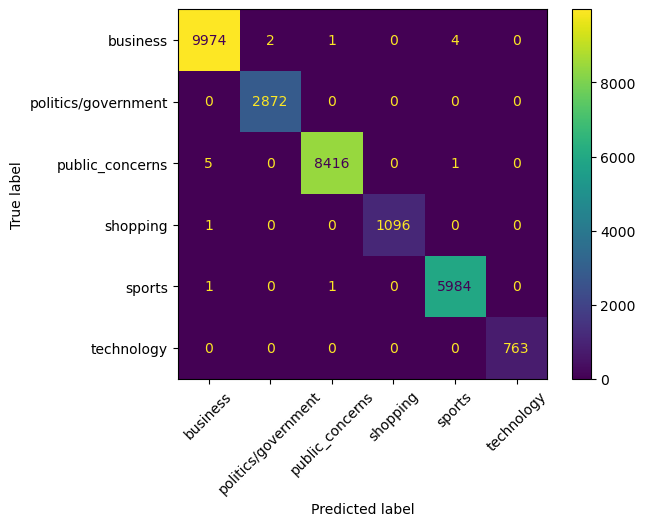

In [21]:
#confusion_matrix(Ytopic_train, Ytopic_pred)
cm_train = confusion_matrix(Ytopic_train, Ytopic_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels = model_topic_class.classes_)
disp_train.plot()
plt.xticks(rotation=45)
plt.show()

### Test/Evaluate Model on Test dataset:

In [22]:
# Test/validate the model on test dataset 
# and output evaluation metrics:

Ytopic_pred = model_topic_class.predict(Xtopic_test_tf)
print ('Accuracy Score - ', accuracy_score(Ytopic_test, Ytopic_pred))
#print ('F1 Score - ', recall_score(Y_test, Y_pred))

Accuracy Score -  0.9544018678752919


In [23]:
print('\n clasification report:\n', classification_report(Ytopic_test,Ytopic_pred))



 clasification report:
                      precision    recall  f1-score   support

           business       0.94      0.96      0.95      2496
politics/government       0.98      0.95      0.97       718
    public_concerns       0.94      0.95      0.95      2105
           shopping       0.99      0.87      0.93       274
             sports       0.97      0.98      0.97      1497
         technology       0.99      0.93      0.96       191

           accuracy                           0.95      7281
          macro avg       0.97      0.94      0.95      7281
       weighted avg       0.95      0.95      0.95      7281



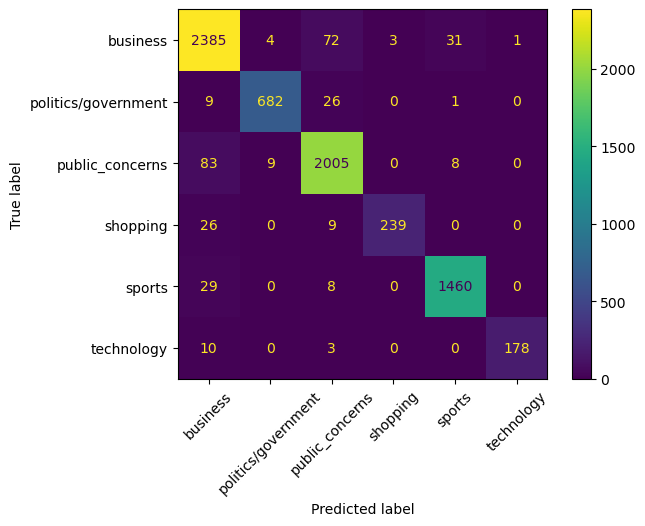

In [24]:
#Y_pred = model_topic_class.predict(X_test_tf)
confusion_matrix(Ytopic_test, Ytopic_pred)
cm = confusion_matrix(Ytopic_test, Ytopic_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = model_topic_class.classes_)
disp.plot()
plt.xticks(rotation=45)
plt.show()

---

Recall and Accuracy values for all classes were above 90% for the SVC topic classification model, which surpasses the required evaluation metrics for the model. 

---

## Other models attempted:

### Random Forest:

In [25]:
parametersRF = {'n_estimators':[500, 1000]}
#parametersRF={'bootstrap': [True, False],
#              'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#              'max_features': ['auto', 'sqrt'],
#              'min_samples_leaf': [1, 2, 4],
#              'min_samples_split': [5, 10],
#              'n_estimators': [1000, 1200]}
svc_gridRF = RandomForestClassifier(random_state=0)
clf_gridRF = GridSearchCV(svc_gridRF, parametersRF, refit=True, verbose=1)
clf_gridRF.fit(Xtopic_train_tf, Ytopic_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


---

Took prohibitivelly too long to test out all combinations. It is understood that most of the time the best indicator for best random forest performance has to do with n_estimators parameter. 

At n_estimators = 20, accuracy of test data was 82% and the minority class had a low recall, at 43%.

To see if there can be better accuracy and recall of the minority class, maximized this parameter at n_estimators = 1000, it took ~36 min to train, and 50s to run predictions in real-time. Accuracy improved to 92% but the recall for the minority class remained low at 52%. 

Rebalancing data to achieve better results in Random Forest was not considered worthwhile given the superior results using SVC without having to artificially modify the data.

---

In [ ]:
clf_gridRF.best_params_

In [24]:
RFclassifier = RandomForestClassifier(n_estimators=1000, random_state=0)
RFclassifier.fit(Xtopic_train_tf, Ytopic_train) 


RandomForestClassifier(n_estimators=1000, random_state=0)

In [25]:

RFYtopic_train_pred = RFclassifier.predict(Xtopic_train_tf)

print ('Training Accuracy Score - ', accuracy_score(Ytopic_train, RFYtopic_train_pred))

Training Accuracy Score -  0.9999656605198998


In [26]:
print('\n Random Forest training clasification report:\n', 
      classification_report(Ytopic_train,RFYtopic_train_pred))


 Random Forest training clasification report:
                      precision    recall  f1-score   support

           business       1.00      1.00      1.00      9981
politics/government       1.00      1.00      1.00      2872
    public_concerns       1.00      1.00      1.00      8422
           shopping       1.00      1.00      1.00      1097
             sports       1.00      1.00      1.00      5986
         technology       1.00      1.00      1.00       763

           accuracy                           1.00     29121
          macro avg       1.00      1.00      1.00     29121
       weighted avg       1.00      1.00      1.00     29121



In [27]:
RFYtopic_pred = RFclassifier.predict(Xtopic_test_tf)
print ('Accuracy Score - ', accuracy_score(Ytopic_test, RFYtopic_pred))
#print ('F1 Score - ', recall_score(Y_test, Y_pred))

Accuracy Score -  0.9215767064963604


In [28]:
print('\n clasification report:\n', classification_report(Ytopic_test,RFYtopic_pred))



 clasification report:
                      precision    recall  f1-score   support

           business       0.88      0.94      0.91      2496
politics/government       0.97      0.88      0.93       718
    public_concerns       0.92      0.94      0.93      2105
           shopping       0.98      0.69      0.81       274
             sports       0.97      0.97      0.97      1497
         technology       1.00      0.52      0.69       191

           accuracy                           0.92      7281
          macro avg       0.95      0.83      0.87      7281
       weighted avg       0.92      0.92      0.92      7281



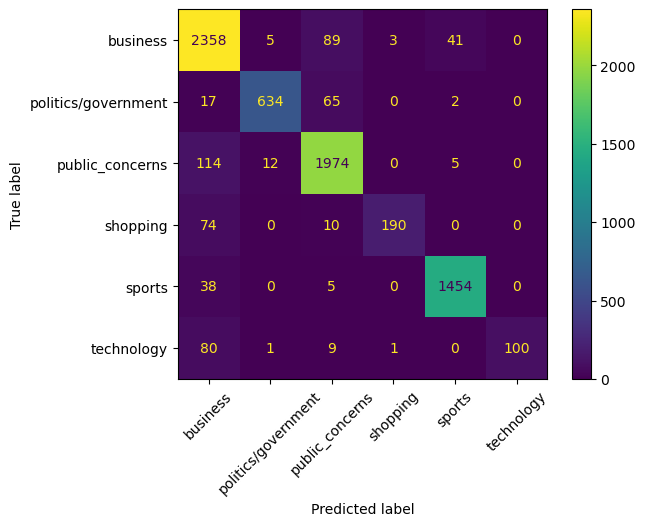

In [29]:
confusion_matrix(Ytopic_test, RFYtopic_pred)
cmRF = confusion_matrix(Ytopic_test, RFYtopic_pred)
dispRF = ConfusionMatrixDisplay(confusion_matrix=cmRF, display_labels = RFclassifier.classes_)
dispRF.plot()
plt.xticks(rotation=45)
plt.show()

### Multi-Label, Multi-Class Random Forest Model:

In [ ]:


'''Obtain row-wise proportions for W matrix and convert top 3 topics over a
threshold for each document to a (n, t) binary array, where n is the
number of records and t is the number of topics citation:
https://chat.openai.com/share/c8cbd38a-b024-4915-939d-cf5f9209926b
'''
np.set_printoptions(suppress=True,
                    precision=4)

# Calculate the row totals
row_totals = np.sum(text_matrix, axis=1)

# Divide each element in the array by its corresponding row total
row_proportions = text_matrix / row_totals[:, np.newaxis]


# Define the threshold for selection (0.33 in this case)
threshold = 0.33
n_top = 5

# Create an empty array to store the results
topic = np.zeros((len(row_proportions), 10), dtype=int)

for idx, row in enumerate(row_proportions):
    # Get indices of elements that satisfy the condition: above the threshold
    above_threshold_indices = np.where(row > threshold)[0]
    
    # Sort the indices based on their corresponding values in descending order
    sorted_indices = above_threshold_indices[np.argsort(row[above_threshold_indices])[::-1]]
    
    # Choose the top X indices if available, or fewer if there are fewer elements above the threshold
    top_3_indices = sorted_indices[:min(n_top, len(sorted_indices))]
    
    # Set the corresponding elements in the 'topic' array to 1
    topic[idx, top_3_indices] = 1


api_data_complete_df['multilabel'] = topic.tolist()

out_cols = ['text_id', 'source_name', 'processed_text']


In [ ]:
Xtopic_train_RF, Xtopic_test_RF, Ytopic_train_RF, Ytopic_test_RF = train_test_split(api_data_complete_modeling_df['clean_processed_text'],
                                                    api_data_complete_modeling_df['multilabel'],
                                                    test_size=0.2,
                                                    random_state=42#,
                                                    #stratify=api_data_complete_modeling_df['multilabel']
                                                    )

print('Size of Training Data ', Xtopic_train_RF.shape[0])
print('Size of Test Data ', Xtopic_test_RF.shape[0])

Size of Training Data  29121
Size of Test Data  7281


In [ ]:
tfidf_topicmodel_RF = TfidfVectorizer(min_df = 10, max_df=0.7, ngram_range=(1,2), stop_words=sw)
Xtopic_train_tf_RF = tfidf_topicmodel_RF.fit_transform(Xtopic_train_RF)
Xtopic_test_tf_RF = tfidf_topicmodel_RF.transform(Xtopic_test_RF)

In [ ]:
n_samples, n_features = Xtopic_train_tf_RF.shape # 10,100

#Ytopic_train_RF
n_outputs = Ytopic_train_RF.shape # 3

mlb = MultiLabelBinarizer()
Ytopic_train_RF_bin = mlb.fit_transform(Ytopic_train_RF)



In [ ]:
Ytopic_test_RF_bin = mlb.transform(Ytopic_test_RF)

In [ ]:
n_classes = 10
forest = RandomForestClassifier(random_state=1)

start_time = time.perf_counter()
multi_target_forest = MultiOutputClassifier(forest)
multi_target_forest.fit(Xtopic_train_tf_RF, Ytopic_train_RF_bin)
end_time = time.perf_counter()
print(f'\nElapsed processing time = {(end_time - start_time) / 60} mins')


Elapsed processing time = 1.919566553333425 mins


In [ ]:
api_data_complete_df.head()

,index,text_id,source_name,author,title,url,publish_date,article_text,content,processed_text,processed_text_split,num_tokens,original_word_count,clean_processed_text,topic,topic_name,topic_name_2nd,topic_name_3rd,customer_topics,multilabel
0,0,2,USA Today,"USA TODAY, Emily DeLetter, USA TODAY","Tito's launches 'Tito's in a Big Can,' an empt...",https://www.usatoday.com/story/money/food/2023...,2023-06-21,Have you ever wanted to own your very own keg ...,Have you ever wanted to own your very own keg ...,ever wanted keg titos handmade vodka dream bec...,"['ever', 'wanted', 'keg', 'titos', 'handmade',...",117,202,ever wanted keg titos handmade vodka dream bec...,2.0,amazon review,business work,,shopping,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0]"
1,1,3,USA Today,"USA TODAY, Joy Ashford, USA TODAY",Search for missing actor Julian Sands continue...,https://www.usatoday.com/story/entertainment/c...,2023-06-20,Over five months after Julian Sands went missi...,Over five months after Julian Sandswent missin...,five months julian sands went missing solo hik...,"['five', 'months', 'julian', 'sands', 'went', ...",215,340,five months julian sands went missing solo hik...,9.0,police court,titanic submersible,,public_concerns,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 1]"
2,2,5,USA Today,Tar Heels Wire,Four star running back picks Michigan State ov...,https://tarheelswire.usatoday.com/2023/06/24/f...,2023-06-25,\n\n\n\n\n\n\n\n\n\n\n\n\n\nFour star running ...,Mack Brown and the UNC football program have b...,four star running back picks michigan state un...,"['four', 'star', 'running', 'back', 'picks', '...",161,286,four star running back picks michigan state un...,0.0,season draft,,,sports,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,3,6,USA Today,Roll Tide Wire,Alabama center Charles Bediako signs one-year ...,https://rolltidewire.usatoday.com/2023/06/23/a...,2023-06-23,\n\n\n\n\n\n\n\n\n\n\n\n\n\nAlabama center Cha...,Alabama center Charles Bediako was signed to a...,alabama center charles bediako signs one year ...,"['alabama', 'center', 'charles', 'bediako', 's...",237,381,alabama center charles bediako signs one year ...,0.0,season draft,,,sports,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,4,7,USA Today,Celtics Wire,Ralph Sampson breaks down iconic Boston Celtic...,https://celticswire.usatoday.com/2023/06/23/nb...,2023-06-23,\n\n\n\n\n\n\n\n\n\n\n\n\n\nRalph Sampson brea...,It was one of the most memorable moments in NB...,ralph sampson breaks iconic boston houston roc...,"['ralph', 'sampson', 'breaks', 'iconic', 'bost...",134,228,ralph sampson breaks iconic boston houston roc...,0.0,season draft,,,sports,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [ ]:
#writable_nlm_train_x01_mtx = np.copy(nlm_train_x01_mtx)

y_pred_RF= multi_target_forest.predict(Xtopic_train_tf_RF)
#train_RF_CM = confusion_matrix(Ytopic_train_RF_bin, y_pred_RF)

print(classification_report(Ytopic_train_RF_bin, y_pred_RF))
#print(train_RF_CM)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29121
           1       1.00      1.00      1.00     27480

   micro avg       1.00      1.00      1.00     56601
   macro avg       1.00      1.00      1.00     56601
weighted avg       1.00      1.00      1.00     56601
 samples avg       1.00      1.00      1.00     56601



In [ ]:

y_pred_test_RF= multi_target_forest.predict(Xtopic_test_tf_RF)
#test_RF_CM = confusion_matrix(Ytopic_test_RF_bin, y_pred_test_RF)

print(classification_report(Ytopic_test_RF_bin, y_pred_test_RF))
#print(test_RF_CM)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7281
           1       0.95      1.00      0.98      6868

   micro avg       0.98      1.00      0.99     14149
   macro avg       0.98      1.00      0.99     14149
weighted avg       0.98      1.00      0.99     14149
 samples avg       0.98      1.00      0.98     14149



In [ ]:
# Start timer script
start_time = dt.datetime.today()

# Citation: Hochberg, 2018; Shanmukh, 2021
m1v1_rfc_pip = Pipeline([('rfc',
                          RandomForestClassifier(random_state=random_state))])

rskf_splits = 2
rskf_repeats = 2
bsg_iters = 5
bsg_jobs = 2

#loss_hparam = Categorical(['log_loss', 'exponential'])
#lrate_hparam = Real(1e-3, 1e3, prior='log-uniform')
#nest_hparam = Integer(1e2, 1e3, prior='log-uniform')

nest_hparam = Integer(1e2, 1e3, prior='log-uniform')
mndepth_hparam = Integer(1e0, 1e2, prior='log-uniform')
mnsamps_hparam = Integer(1e0, 1e2, prior='log-uniform')
mnsampl_hparam = Integer(1e0, 1e2, prior='log-uniform')
mxfeat_hparam = Categorical(['sqrt', 'log2', None])
minimpd_hparam = Real(1e-3, 1e3, prior='log-uniform')
oob_hparam = Categorical([True, False])
ccp_hparam = Real(1e-3, 1e3, prior='log-uniform')
maxsamp_hparam = Real(1e-3, 1e0, prior='log-uniform')

m1v1_rfc_grd = {'rfc__n_estimators': nest_hparam,
                'rfc__max_depth': mndepth_hparam,
                'rfc__min_samples_split': mnsamps_hparam,
                'rfc__min_samples_leaf': mnsampl_hparam,
                'rfc__max_features': mxfeat_hparam,
                'rfc__min_impurity_decrease': minimpd_hparam,
                'rfc__oob_score': oob_hparam,
                'rfc__ccp_alpha': ccp_hparam,
                'rfc__max_samples': maxsamp_hparam,
               }

'''Change rfc default scoring from accuracy to F1 score citation:
https://chat.openai.com/share/254f382b-4a8e-48e8-acd5-2918f0bbc59d
'''
f1_scorer = make_scorer(f1_score,
                        pos_label='right')

'''Customize cross-validation citation:
https://machinelearningmastery.com
/scikit-optimize-for-hyperparameter-tuning-in-machine-learning/
'''
cv = RepeatedStratifiedKFold(n_splits=rskf_splits,
                             n_repeats=rskf_repeats,
                             random_state=random_state)

m1v1_rfc = BayesSearchCV(m1v1_rfc_pip,
                         m1v1_rfc_grd,
                         n_iter=bsg_iters,
                         scoring=None,
                         cv=cv,
                         n_jobs=bsg_jobs,
                         refit=True,
                         verbose=4,
                         random_state=random_state)

m1v1_rfc.fit(nlm_train_x01_mtx, nlm_train_y01)

# End timer script
end_time = dt.datetime.today()
time_elapse = end_time - start_time
print(f'Start Time = {start_time}')
print(f'End Time = {end_time}')
print(f'Elapsed Time = {time_elapse}')

### Pickle best model

In [ ]:
# Path to save the pickled model
mod_folder_name = 'trained_models'
m1v1_pkl_file_name = 'm1v1_rfc.pkl'

pkl_file_path01 = os.path.join(curr_dir, mod_folder_name, m1v1_pkl_file_name)

print(f'Pickle file 1 in path: {pkl_file_path01}')

### Load pickled best model

In [ ]:
with open(pkl_file_path01, 'rb') as file:
    m1v1_rfc = pickle.load(file)

In [ ]:
print(f'\nBest Estimator:\n{m1v1_rfc.best_estimator_}')

print('\nCross-validaton results:')
display(pd.DataFrame(m1v1_rfc.cv_results_))

train_m1v1_rfc_y01_pred = m1v1_rfc.predict_proba(nlm_train_x01_mtx)
print(f'\nFirst 10 train set predictions:\n{train_m1v1_rfc_y01_pred[:10]}')

test_m1v1_rfc_y01_pred = m1v1_rfc.predict_proba(nlm_test_x01_mtx)
print(f'\nFirst 10 test set predictions:\n{test_m1v1_rfc_y01_pred[:10]}')

print(f'\nBest Score for "{m1v1_rfc.scorer_}" is {m1v1_rfc.best_score_}')

#### Train set check

In [ ]:
nlm_train_y01_pred = m1v1_rfc.predict(nlm_train_x01_mtx)
nlm_train_y01_pred_cm = confusion_matrix(nlm_train_y01, nlm_train_y01_pred)

print(classification_report(nlm_train_y01, nlm_train_y01_pred))
print(nlm_train_y01_pred_cm)

'''Citation:
https://scikit-learn.org/stable/modules/generated
/sklearn.metrics.ConfusionMatrixDisplay.html
#sklearn.metrics.ConfusionMatrixDisplay.plot
'''
nlm_train_cm_dsp = ConfusionMatrixDisplay(confusion_matrix=nlm_train_y01_pred_cm,
                                          display_labels=m1v1_rfc.classes_)
nlm_train_cm_dsp.plot()
plt.show()

#### ROC-AUC Curve

In [ ]:
nlm_train_y01_pred_decf = m1v1_rfc.decision_function(nlm_train_x01_mtx)
RocCurveDisplay.from_predictions(nlm_train_y01, nlm_train_y01_pred_decf,
                                 pos_label='right')
plt.show()

#### Test set results

In [ ]:
nlm_test_y01_pred = m1v1_rfc.predict(nlm_test_x01_mtx)
nlm_test_y01_pred_cm = confusion_matrix(nlm_test_y01, nlm_test_y01_pred)

print('Test Set Evaluation Metrics')
print(classification_report(nlm_test_y01, nlm_test_y01_pred))
print(nlm_test_y01_pred_cm)

'''Citation:
https://scikit-learn.org/stable/modules/generated
/sklearn.metrics.ConfusionMatrixDisplay.html
#sklearn.metrics.ConfusionMatrixDisplay.plot
'''
nlm_test_cm_dsp = ConfusionMatrixDisplay(confusion_matrix=nlm_test_y01_pred_cm,
                                         display_labels=m1v1_rfc.classes_)
nlm_test_cm_dsp.plot()
plt.show()

#### Variable importance

In [ ]:
print(nlm_train_x01_mtx_cols)
print(type(nlm_train_x01_mtx_cols))
print(nlm_train_x01_mtx_cols.shape)

x = m1v1_rfc.best_estimator_.named_steps['rfc'].feature_importances_
x_df01 = pd.DataFrame(x, columns=['var_imp'])
x_df01['feature'] = nlm_train_x01_mtx_cols
x_df02 = x_df01.sort_values(by=['var_imp'], ascending=False)
x_df03 = x_df02.head(20)

display(x_df02.head())
print(type(x_df02))
print(x_df02.shape)

In [ ]:
'''Citation:
https://machinelearningmastery.com/calculate-feature-importance-with-python/
'''
# plot feature importance
#figure = plt.figsize((10,9))
plt.figure(figsize=(15,7))
plt.title('Feature Importance (Top 20)')
plt.barh([x for x in range(len(x_df03['var_imp']))], x_df03['var_imp'],
         tick_label=x_df03['feature'])
plt.show()

In [ ]:
TNmodel1=nlm_test_y01_pred_cm[0][0]
FPmodel1=nlm_test_y01_pred_cm[0][1]
FNmodel1=nlm_test_y01_pred_cm[1][0]
TPmodel1=nlm_test_y01_pred_cm[1][1]

In [ ]:
# Results:
from tabulate import tabulate

TANmodel1=TNmodel1+FPmodel1
TAPmodel1=TPmodel1+FNmodel1
TPPmodel1=FPmodel1+TPmodel1
TPNmodel1=TNmodel1+FNmodel1
GTmodel1=TANmodel1+TAPmodel1
AccuracyM1=(TNmodel1+TPmodel1)/GTmodel1
ErrorRateM1=1-AccuracyM1
SensitivityM1=TPmodel1/(TAPmodel1)
RecallM1=SensitivityM1
SpecificityM1=TNmodel1/TANmodel1
PrecisionM1=TPmodel1/TPPmodel1
F1M1=2*PrecisionM1*RecallM1/(PrecisionM1 + RecallM1)
F2M1=5*(PrecisionM1*RecallM1)/((4*PrecisionM1)+RecallM1)
Fp5M1=(1.25)*(PrecisionM1*RecallM1)/((0.25*PrecisionM1)+RecallM1)

header = ["Accuracy", "Error Rate", "Sensitivity", "Recall", "Specificity",
          "Precision", "F1", "F2", "F0.5"]
data1 = [["Accuracy", AccuracyM1], ["Error Rate", ErrorRateM1],
         ["Sensitivity", SensitivityM1],
         ["Recall", RecallM1], ["Specificity", SpecificityM1],
         ["Precision", PrecisionM1],
         ["F1", F1M1], ["F2", F2M1], ["F0.5", Fp5M1]]

col_names=["Measurement", "Linear SVC Model"]

ModelEvaluationTable = tabulate(data1, headers=col_names,
                                tablefmt="fancy_grid")

print(ModelEvaluationTable)